In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
import json
from helpers import style
from helpers.afa import adaptive_filter
from itertools import groupby
from tqdm import tqdm
from collections import Counter
from itertools import combinations
from collections import defaultdict
import cdlib
import networkx as nx
import random

from helpers.linkage import mutual_information_smooth
from helpers.pathtools import *
from helpers.metrics import *
from helpers.visuals import add_cabinet_periods

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

style.load_style()

from helpers.dataloader import load

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'infomap', 'graph_tool', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [2]:
dists, dat, keys = load(quick_return=True)

In [3]:
## Dists for Linkage Calculation
dists = dists.groupby(dat[['topic_id','member-ref']].astype(str).agg('_'.join,axis=1)).mean()
topic_sesst = dict(zip(dat.topic_id,dat.sess_type))
topic_dates = dict(zip(dat.topic_id,dat.date))
topic_dates = {topic:pd.Timestamp(year = _.year, month = 1 if _.month < 7 else 6, day = 1) for topic,_ in topic_dates.items()}

dists = dists[dists.index.str.split('_').str[0].map(topic_sesst) == 'plenary']

dists = dists[[v for v in dists.columns if 'rhet' not in keys[int(v)] and 'nonse' not in keys[int(v)] and 'proc' not in keys[int(v)]]]
dists = dists.div(dists.sum(axis=1), axis=0)

# Select TOPIC-MEMBER pairs based on above-average topic use
tm_dates = {i:(topic_dates[i.split('_')[0]],i.split('_')[1]) for i in dists.index}
mb_per_top = dists.groupby(dists.index.map(tm_dates)).mean().apply(zscore,axis=0)
mb_per_top_d = mb_per_top.apply(lambda row: row[row > 0].index.tolist(), axis=1).to_dict()

# Filter Dists
dists.index = dists.index.str.split('_').str[0].map(topic_dates)

dz = dists.apply(zscore,axis=0)
dists = dists.where(dz >= 0, 0.0000000000001)
dists = dists.div(dists.sum(axis=1), axis=0)

In [4]:
communities = {}
networks = {}

for cd,(date, _) in tqdm(enumerate(dists.groupby(dists.index))):
    rij, ri, m = mutual_information_smooth(theta = _.to_numpy())
    rij = pd.DataFrame(rij, index=[keys[int(i)] for i in _.columns], columns=[keys[int(i)] for i in _.columns])
    rij = rij.stack().reset_index().rename(columns={"level_0":"s","level_1":"t",0:"pmi"})
    rij = rij[(rij.s != rij.t) & (rij.pmi > 0)]
    g = nx.from_pandas_edgelist(df = rij, source='s', target='t', edge_attr='pmi')
    cms = algorithms.leiden(g,weights='pmi').communities
    networks[str(date)] = g
    communities[date] = {}
    for cc,c in enumerate(cms):
        communities[date][cc] = c

95it [00:09, 10.47it/s]


In [5]:
## Connecting Members to Communities
res = {}
dat_long = []
for period in sorted(dists.index.unique()):
    mbd = {mb:[keys[int(v)] for v in tops] for (date,mb),tops in mb_per_top_d.items() if date == period}
    cm_mbd = {comm:[mb for mb,tops in mbd.items() if overlap_coefficient(set(tps),set(tops)) > .35] for comm,tps in communities[period].items()}
    if len(cm_mbd.items()) > 1:
        mtd = dat[dat.date.apply(lambda d: pd.Timestamp(year=d.year,month=1 if d.month < 7 else 6,day=1)) == period]
        parties = dict(zip(mtd['member-ref'],mtd['party-ref']))
        res[period] = cm_mbd

        for clusn, members in cm_mbd.items():
            for m in members:
                dat_long.append({"period":period,"clusn":clusn,"mb":m,"party":parties.get(m)})

In [6]:
dl = pd.DataFrame(dat_long)

## Statistics

In [7]:
## Size
dls = dl.groupby('period').size().reset_index(name='n')
dls['n_norm_clusn'] = dls.n / dls.period.apply(lambda p: len(communities[p]))

## Connectivity
dlc = dl.groupby('period').apply(lambda g: g.groupby('mb').size().mean()).reset_index(name='conn')

In [8]:
periods = sorted(dl.period.unique())
res = []

for c,i in enumerate(periods):

    if c == 0:
        continue
    else:
        df = dl[dl.period == i]

        for mb in df.mb.unique():

            nbs_current = df[df.clusn.isin(df[df.mb == mb].clusn.unique())].mb.unique()
            nbs_previous = dl[(dl.clusn.isin(dl[dl.mb == mb].clusn.unique())) & (dl.period == periods[c-1])].mb.unique()
            overlap = overlap_coefficient(set(nbs_current),set(nbs_previous))
            res.append(
                {
                    "mb":mb,
                    "period":i,
                    "overlap_prev":overlap
                }
            )

dlr = pd.DataFrame(res).groupby('period').overlap_prev.mean().reset_index(name='ll')

<Axes: xlabel='period'>

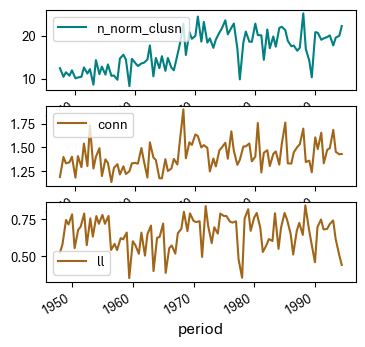

In [9]:
f,a = plt.subplots(3,1,figsize=(4,4))

dls.plot(x='period',y='n_norm_clusn',color='teal',ax=a[0])
dlc.plot(x='period',y='conn',ax=a[1])
dlr.plot(x='period',y='ll',ax=a[2])

# Plotting (test)

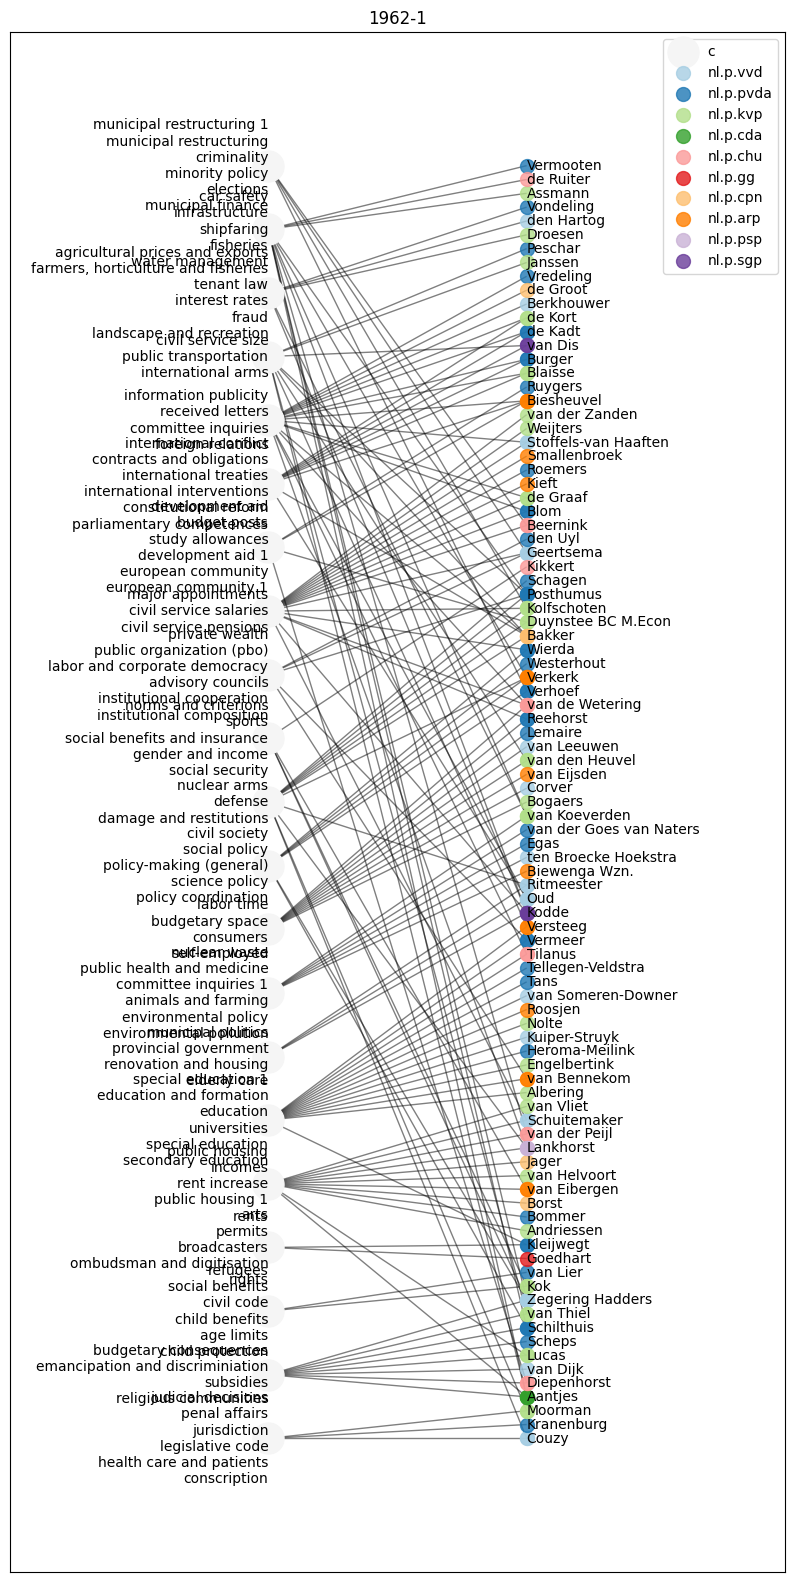

In [142]:
# Create bipartite graph
df_filtered = rcd[rcd.jc > .5]
# Create bipartite graph
B = nx.Graph()
left_nodes = df_filtered['c'].unique()
right_nodes = df_filtered['mb'].unique()

B.add_nodes_from(left_nodes, bipartite=0)  # Add the 'c' nodes
B.add_nodes_from(right_nodes, bipartite=1)  # Add the 'mb' nodes

# Add edges
edges = list(zip(df_filtered['c'], df_filtered['mb']))
B.add_edges_from(edges)

# Remove 'c' nodes with less than 2 incoming edges
nodes_to_remove = [node for node in left_nodes if len(list(B.neighbors(node))) < 2]
B.remove_nodes_from(nodes_to_remove)

# Recalculate left_nodes after removal
left_nodes = [node for node in left_nodes if node not in nodes_to_remove]

# Calculate positions
pos = {}
left_y_positions = list(range(len(left_nodes)))
right_y_positions = list(range(len(right_nodes)))

# Normalize y positions to spread nodes evenly
left_y_positions = [i / (len(left_nodes) - 1) if len(left_nodes) > 1 else 0.5 for i in left_y_positions]
right_y_positions = [i / (len(right_nodes) - 1) if len(right_nodes) > 1 else 0.5 for i in right_y_positions]

# Set positions
pos.update((node, (1, y)) for node, y in zip(left_nodes, left_y_positions))  # left nodes
pos.update((node, (2, y)) for node, y in zip(right_nodes, right_y_positions))  # right nodes

# Assign colors to parties
parties = df_filtered['party'].unique()
party_colors = {party: color for party, color in zip(parties, sns.color_palette('Paired',len(parties)))}

# Create a figure and axis with plt.subplots()
fig, ax = plt.subplots(figsize=(10, 20))

# Draw nodes
nx.draw_networkx_nodes(B, pos, nodelist=left_nodes, node_color='whitesmoke', node_size=500, alpha=1, ax=ax, label='c')
for party in parties:
    nodes = df_filtered[df_filtered['party'] == party]['mb']
    nx.draw_networkx_nodes(B, pos, nodelist=nodes, node_color=[party_colors[party]], node_size=100, alpha=0.8, ax=ax, label=party)

# Draw edges
nx.draw_networkx_edges(B, pos, edgelist=B.edges(), width=1.0, alpha=0.5, edge_color='k', ax=ax)

# Draw labels
nx.draw_networkx_labels(B, pos, labels={node: node for node in left_nodes}, font_size=10, font_color='black', horizontalalignment='right', ax=ax)
nx.draw_networkx_labels(B, pos, labels={node: node for node in right_nodes}, font_size=10, font_color='black', horizontalalignment='left', ax=ax)

# Extend xlim by 10% on both sides
x_values = [pos[node][0] for node in pos]
x_min, x_max = min(x_values), max(x_values)
plt.xlim(x_min - 1 * (x_max - x_min), x_max + 1 * (x_max - x_min))

plt.legend()
plt.title(str(td.year) + '-' + str(td.month))
plt.show()